In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [67]:
import igraph as ig
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import trange, tqdm


# Preprocessing

In [71]:
uber_data = pd.read_csv('../input/uberdataproject/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])

In [81]:
sd = np.hstack((np.asarray(uber_data.sourceid).reshape(-1,1), np.asarray(uber_data.dstid).reshape(-1,1)))
uber_data_ref = np.asanyarray(uber_data)



In [88]:
axis_filter = {}
for x,y,z in tqdm(uber_data_ref):
    key = tuple(np.sort([int(x), int(y)]))
    if key in axis_filter: axis_filter[key].append(z)
    else: axis_filter[key] = [z]

with open('/kaggle/working/axis_filter.txt','w') as f:
    for loc in tqdm(axis_filter):
        f.write('{} {} {:.6f}\n'.format(loc[0], loc[1], np.mean(axis_filter[loc])))

In [90]:
inter_graph = ig.Graph.Read(f = '/kaggle/working/axis_filter.txt', format = 'ncol', directed = False)
gcc = inter_graph.components().giant()


In [108]:
loc_meta = {}
with open('../input/uberdataproject/los_angeles_censustracts.json', 'r') as f:
    data = json.loads(f.readline())
    for feature in data['features']:
        coordinates = np.array(feature['geometry']['coordinates'][0][0])
        loc_meta[feature['properties']['MOVEMENT_ID']] = {'address': feature['properties']['DISPLAY_NAME'],
                                                          'mean_coords': np.mean(coordinates.reshape(-1,2), axis=0)}
        
seq = gcc.vs()
for i in seq:
    i['location'] = loc_meta[i['name']]['mean_coords']
ig.summary(gcc)

IGRAPH UNW- 2649 1004955 -- 
+ attr: location (v), name (v), weight (e)


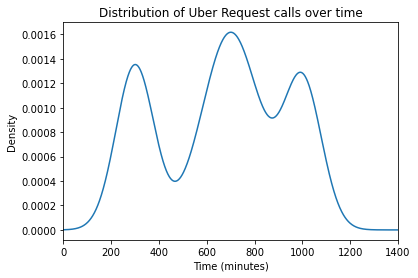

In [124]:
mean1, scale_param1, shape1 = (300, 80, 500)
mean2, scale_param2, shape2 = (700, 120, 900)
mean3, scale_param3, shape3 = (1000, 80, 450)
x2 = np.concatenate([np.random.normal(loc=mean1, scale=scale_param1, size=shape1),
                     np.random.normal(loc=mean2, scale=scale_param2, size=shape2), np.random.normal(loc=mean3, scale=scale_param3, size=shape3)])

pdf_input_arr = np.arange(1440)

uber_call_pdf = stats.norm.pdf(pdf_input_arr, loc=mean1, scale=scale_param1) * float(shape1) / x2.size + \
              stats.norm.pdf(pdf_input_arr, loc=mean2, scale=scale_param2) * float(shape2) / x2.size + \
              stats.norm.pdf(pdf_input_arr, loc=mean3, scale=scale_param3) * float(shape3) / x2.size

uber_call_pdf /= uber_call_pdf.sum()

plt.plot(pdf_input_arr, uber_call_pdf)

plt.xlim([pdf_input_arr.min(), pdf_input_arr.max()])
plt.xlabel('Time (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Uber Request calls over time')
plt.xlim([0, 1400])
ticks=[*range(0,1400,200)]
ticks.append(1400)
plt.xticks(ticks)
plt.show()

In [60]:
print('Uber Call Request PDF shape - ' +str(pdf_input_arr.shape))


Uber Call Request PDF shape - (1440,)


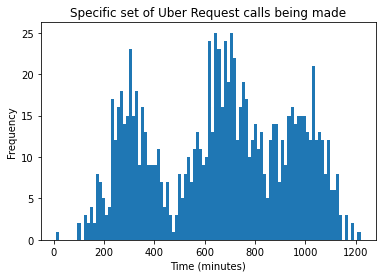

In [125]:
wait_travel_time = np.random.choice(range(1440), 1000, p=uber_call_pdf)

plt.hist(times, 100)
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.title('Specific set of Uber Request calls being made')
plt.show()

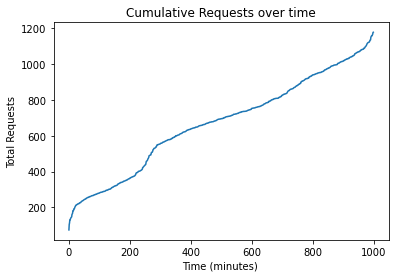

In [96]:
wait_travel_time=np.sort(wait_travel_time)

uber_reqs = []
trips = set()
trip_vs = range(len(gcc.vs()))
counter =0

for i in tqdm(range(1000)):
    trip = np.random.choice(trip_vs, 2, replace=False)
    trip_tup = tuple(np.sort(trip))
    while trip_tup in trips:
        trip = np.random.choice(trip_vs, 2, replace=False)
        trip_tup = tuple(np.sort(trip))
    
    assert(trip_tup not in trips)
    trips.add(trip_tup)
    uber_reqs.append([wait_travel_time[i], trip_tup[0], trip_tup[1]])
    
trip_vs

tuple(np.sort(np.random.choice(trip_vs, 2, replace=False)))
uber_reqs = np.array(uber_reqs)

uber_reqs[0,:]
plt.title('Cumulative Requests over time')
plt.xlabel('Time (minutes) ')
plt.ylabel('Total Requests')
plt.plot(uber_reqs[:,0])


In [110]:
gcc_distances = np.array(gcc.shortest_paths(weights = gcc.es()['weight']))

n_e=0
delta=5
g1_edges = []
for i in trange(1000):
    for j in range(i+1, 1000):
        t1, t2 = uber_reqs[i, 0], uber_reqs[j, 0]
        assert(t1 <= t2)
        src1, dst1 = uber_reqs[i, 1], uber_reqs[i, 2]
        src2, dst2 = uber_reqs[j, 1], uber_reqs[j, 2]
        arriv_at_2 = t1+gcc_distances[src1][dst1]/60+gcc_distances[dst1][src2]/60
        if arriv_at_2 <= t2+delta:
            n_e+=1
            g1_edges.append((i,j))

In [115]:
len(g1_edges)
g1 = ig.Graph(1000, directed=True)
g1.add_edges(g1_edges)
print('Summary of graph ' + str(g1.summary()))

Summary of graphIGRAPH D--- 1000 433140 -- 


In [116]:
length_to = np.zeros(1000, dtype=int)
from_to = np.zeros(1000, dtype=int)-1
top_order = g1.topological_sorting(mode='OUT')

for v in top_order:
    for w in g1.vs(v)[0].neighbors(mode='OUT'):
        if length_to[w.index] <= length_to[v] + 1:
            length_to[w.index] = length_to[v] + 1
            from_to[w.index] = v
            
max_req, endpoint = np.amax(length_to), int(np.argmax(length_to))
print(max_req, endpoint)


33 998


[ 786 1035  754  989  738  873  463  965  830  263  608  897  857  726
  583  981  598  452  744  305  723 1083  962  749  585  459  387  430
  999 1001  620  365  926  417]
[ 130  167  215  255  272  294  329  370  410  462  493  538  564  600
  635  658  693  720  746  777  794  813  835  882  905  934  971  989
 1012 1036 1062 1103 1134 1176]


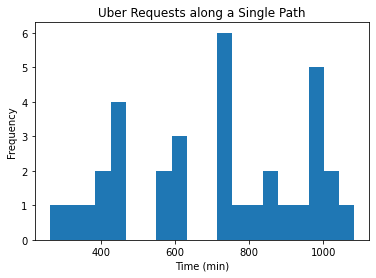

In [126]:
curr=[endpoint]
while curr[-1]!=-1:
    curr.append(from_to[curr[-1]])
    
chosen_path = curr[:-1]
chosen_path.reverse()

with open('/kaggle/working/uber_reqs_single_path.csv', 'w') as f:
    f.write('Longitude, Latitude, Line Group (Path ID), Order of Points, Color \n')
    count=0
    for i,j in enumerate(chosen_path):
        _,l1,l2 = uber_reqs[j]
        locx = gcc.vs[l1]['location']
        locy = gcc.vs[l2]['location']
        f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count+1) + ', ' + str(2*i+1) + ', 2\n')
        f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count+1) + ', ' + str(2*i+2) + ', 2\n')
        
    for i,j,k in uber_reqs:
        locx = gcc.vs[j]['location']
        locy = gcc.vs[k]['location']
        count+=1
        f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count) + ', ' + str(1) + ', 1\n')
        f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count) + ', ' + str(2) + ', 1\n')
        
print(wait_travel_time[chosen_path])
print(uber_reqs[chosen_path, 0])

plt.hist(wait_travel_time[chosen_path], bins=20)
plt.xlabel('Time (min)')
plt.ylabel('Frequency')
plt.title('Uber Requests along a Single Path')
plt.show()

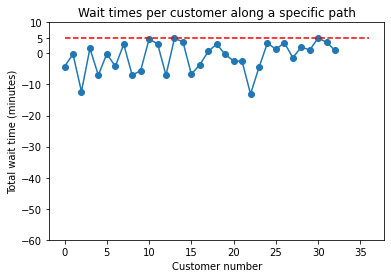

Maximum wait time is 4.974166666666633 minutes


In [127]:
waiting_time = []
for k in range(len(chosen_path)-1):
    i=chosen_path[k]
    j=chosen_path[k+1]
    t1, t2 = uber_reqs[i, 0], uber_reqs[j, 0]
    src1, dst1 = uber_reqs[i, 1], uber_reqs[i, 2]
    src2, dst2 = uber_reqs[j, 1], uber_reqs[j, 2]
    arriv_at_2 = t1+gcc_distances[src1][dst1]/60+gcc_distances[dst1][src2]/60
    #print(arriv_at_2, t2+delta)
    assert(arriv_at_2 <= t2+delta)
    waiting_time.append(arriv_at_2-t2)

    
plt.plot(waiting_time, '-o')
plt.xlabel('Customer number')
plt.ylabel('Total wait time (minutes)')
plt.ylim([-60, 10])
ticks=[*range(-60,11,10)]
ticks.append(5)
plt.yticks(ticks)
plt.title('Wait times per customer along a specific path')
plt.plot([0, 36],[5,5], '--r')
plt.show()

print('Maximum wait time is ' + str(max(waiting_time)) + ' minutes')